## Advanced simulation with Shyft

### Introduction
In [Part I](run_nea_nidelva.ipynb) of the simulation tutorials, we covered conducting a very simple simulation of an example catchment using configuration files. This is a typical use case, but assumes that you have a model well configured and ready for simulation. In practice, one is interested in working with the model, testing different configurations, and evaluating different data sources.

This is in fact a key idea of Shyft -- to make it simple to evaluate the impact of the selection of model routine on the performance of the simulation. In this notebook we walk through a lower level paradigm of working with the toolbox and using the Shyft API directly to conduct the simulations.

#### This notebook is guiding through the simulation process of a catchment. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Running of a Shyft simulation**
3. **Running a Shyft simulation with updated parameters**
4. **Activating the simulation only for selected catchments**
5. **Setting up different input datasets**
6. **Changing state collection settings**
7. **Post processing and extracting results**

### Loading the required modules and setting the environment

As before, we have to make sure our python environment is set up for conducing simulations with Shyft and load the appropriate modules and libraries.

In [3]:
# Imports for data processing
%matplotlib inline
import datetime as dt
import os
import sys
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

# Shyft imports
from shyft import api
from shyft.orchestration.configuration.yaml_configs import YAMLSimConfig
from shyft.orchestration.simulators.config_simulator import ConfigSimulator
# 1.Setting up a simulator using configuration saved on file
config_file_path = os.path.abspath("./nea-config/neanidelva_simulation.yaml")
cfg = YAMLSimConfig(config_file_path, "neanidelva")
simulator = ConfigSimulator(cfg)


### Exploring the Shyft API
In the following section we'll explore several components of the `shyft.api`. We consider the strength of Shyft to lie within this Application Programming Interface, or API. To the uninitiated, it adds quite a degree of complexity. However, once you understand the different components and paradigms of Shyft, you'll see the flexibility the API offers provides a great number of possibilities for exploring hydrologic simulations.

To start, as in the first tutorial, we'll start with a `YAMLSimConfig` object and create a `ConfigSimulator`. This will get us going quickly and provide a `region_model` as a starting point. But in this tutorial, the point is to work more closely with different components of the `Shyft.api`. In particular, we hope to demonstrate how the underlying `region_model`, rather than a `simulator`, is developed. The latter is just a wrapper that is made for convenience when running models operationally. If one is interested in working with Shyft to explore algorithm performance, it is easier to work directly with the `region_model` class.

The API approach will take a bit more code to get started, but will allow great flexibility later on. The first thing we'll do is to expose several of the attributes (which are mostly Shyft API classes) of the `simulator` object. Let's begin by getting those in our namespace:

In [4]:
# expose attributes of the simulator
region_model = simulator.region_model
region_model_id = simulator.region_model_id
interpolation_id = simulator.interpolation_id
 

In the [first tutorial](run_nea_nidelva.ipynb#The-simulator-and-the-region_model) we discussed the `region_model`. If you are unfamiliar with this class, we recommend reviewing the [description](region_model.rst). 

#### The concept of Shyft repositories

In Shyft, we consider that input data is a "source". Our source data resides in some kind of data serialization... be it a text file, netcdf file, or database... One could have any kind of storage format for the source data. [Repositories](repositories.rst) are Python based interfaces to data. Several have been created within Shyft already, but users are encouraged to create their own. A guiding paradigm to Shyft is that data should live as close to the source as possible (ideally, at the source). The repositories connect to the data source and make the data available to Shyft.

In [5]:
# expose the repositories
region_model_repo = simulator.region_model_repository
interpolation_param_repo = simulator.ip_repos
geo_ts_repo = simulator.geo_ts_repository
initial_state_repo = simulator.initial_state_repo

Now we have exposed the **repositories** that we connected to our `region_model` during configuration. Having access to the repositories, means that we have access to the input data sources directly (found in `geo_ts_repository`). We also have several other repositories, including a repository for the interpolation parameters, initial state, and the region_model. We'll explore some of these a bit deeper now. But first we'll expose a few more pieces of information from the region_model while we're at it.

In [6]:
epsg = region_model.bounding_region.epsg()
bbox = region_model.bounding_region.bounding_box(epsg)
period = region_model.time_axis.total_period()
geo_ts_names = ("temperature", "wind_speed", "precipitation", "relative_humidity", "radiation")
sources = geo_ts_repo.get_timeseries(geo_ts_names, period, geo_location_criteria=bbox)

The `epsg` is simply the domain projection information for our simulation. `bbox` provides the bounding box coordinates. `period` gives the total period of the simulation. Lastly, we create a tuple of the 'geolocated timeseries names' or `geo_ts_names` as it is referred to here. And use this to get the *sources* out of our repository. Note that these names:

    temperature
    wind_speed
    precipitation
    relative_humidity
    radiation
    
Are embedded into Shyft as timeseries names that are required for simulations. In the current implementations, these are the default names used in repositories and, at present, the only forcing data required. If one were to develop new algorithms that reqiured other forcings, you would need to define these in a custom repository. See `interfaces.py` for more details.

Before going further, let's look at what we have so far...

We won't look in detail at all the repositories, but let's take a look at the `geo_ts_repo`:

In [7]:
# explore geo_ts_repo
#help(geo_ts_repo)

The `geo_ts_repo` is a collection of geolocated timeseries repositories. Note that `geo_ts_repo` has an attribute: `.geo_ts_repositories`... this seems redundant? This is simply a list of the repositories this class is 'managing'.

Maybe we want to look at the precipitation input series in more detail. We can get at those via this class. NOTE, this may not be the most typical way to look at your input data (presumably you may have already done this before the simulation working with the raw netcdf files), but in case you wish to see the datasets from the "model" perspective, this is how you gain access. Also, maybe you want to conduct a simulation, then make a data correction. You could do that by accessing the values here. Each of the aforementioned series types have a specialized source vector type in Shyft. In the case of precipitation it is a `api.PrecipitationSourceVector`. If we dig into this, we'll find some aspects familiar from the first tutorial.

Let's get the precipitation timeseries out of the repository for the period of the simulation first:

In [8]:
# above we already created a `sources` dictionary by
# using the `get_timeseries` method. This method takes a 
# list of the timeseries names as input and a period 
# of type 'shyft.api._api.UtcPeriod'
# it returns a dictionary, keyed by the names of the timeseries
prec = sources['precipitation']

# `prec` is now a `api.PrecipitationSourceVector` and if you look
# you'll see it 10 elements:
print(len(prec))


10


We can explore further and see each element is in itself an `api.PrecipitationSource`, which has a timeseries (ts). Recall from the [first tutorial](run_nea_nidelva.ipynb#Visualizing-the-discharge-for-each-[sub-]catchment) that we can easily convert the `timeseries.time_axis` into datetime values for plotting.

Let's plot the precip of each of the sources:

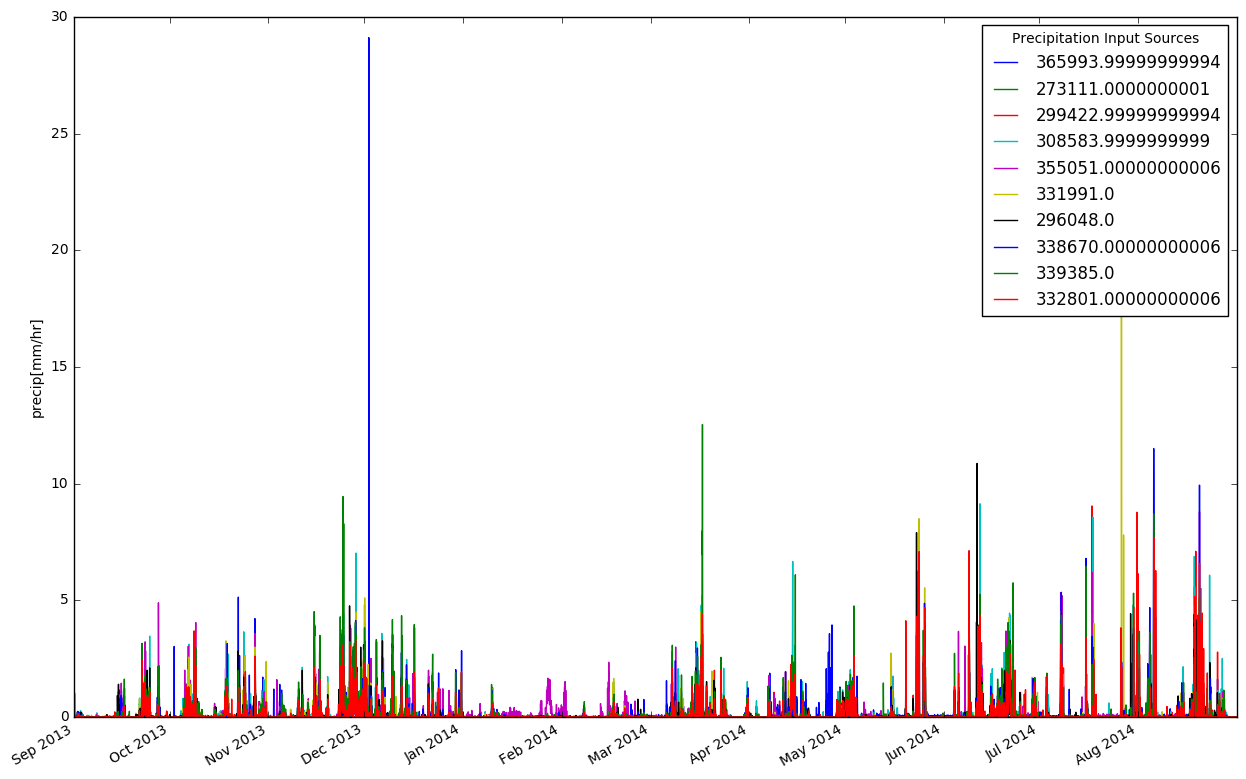

In [9]:
fig, ax = plt.subplots(figsize=(15,10))

for pr in prec:
    t,p = [dt.datetime.utcfromtimestamp(t_.start) for t_ in pr.ts.time_axis], pr.ts.values
    ax.plot(t,p, label=pr.mid_point().x) #uid is empty now, but we reserve for later use
fig.autofmt_xdate()
ax.legend(title="Precipitation Input Sources")
ax.set_ylabel("precip[mm/hr]")

Before we leave this section, we can also take a quick look at the `interpolation_param_repo`. This is a different type of repository, and it contains the parameters that will be passed to the interpolation algorithm to take a point-source timeseries and interpolate them to the Shyft cells, or in the context of of the API: `region_model.cells`. We'll quickly look at the `.params` attribute, which is a dictionary.

In [10]:
interpolation_param_repo.params

{'precipitation': {'method': 'idw',
  'params': {'distance_measure_factor': 1.0,
   'max_distance': 600000.0,
   'max_members': 10,
   'scale_factor': 1.02}},
 'radiation': {'method': 'idw',
  'params': {'distance_measure_factor': 1.0,
   'max_distance': 600000.0,
   'max_members': 10}},
 'relative_humidity': {'method': 'idw',
  'params': {'distance_measure_factor': 1.0,
   'max_distance': 600000.0,
   'max_members': 10}},
 'temperature': {'method': 'btk',
  'params': {'nug': 0.5,
   'range': 200000.0,
   'sill': 25.0,
   'temperature_gradient': -0.6,
   'temperature_gradient_sd': 0.25,
   'zscale': 20.0}},
 'wind_speed': {'method': 'idw',
  'params': {'distance_measure_factor': 1.0,
   'max_distance': 600000.0,
   'max_members': 10}}}

One quickly recognizes the same input source type keywords that are used as keys to the `params` dictionary. `params` is simply a dictionary of dictionaries which contains the parameters used by the interpolation model that is specific for each source type.

In closing, one is encouraged to understand well the concept of the **repositories**. As a user of Shyft, it is likely you'll want to create your own repository to access your data directly rather than creating input files for Shyft. Keep in mind that the repositories are Python code, and not a part of the core C++ code of Shyft. They are designed to provide an interface between the C++ code and potentially more 'pythonic' paradigms. In the following section, you'll see that we populate a C++ class from a repository collection.

#### The ARegionEnvironment class

The next thing we'll do is to create an `api.ARegionEnvironment` class to use in our custom simulation. As the `geo_ts_repo` was a Python interface that provided a collection of all the timeseries repositories, the `region_env` is an API type that provides a container of the "sources" of data specific to the model. We will now create an `api.ARegionEnvironment` from the `geo_ts_repo`. It may be helpful to think of a `region_env` as the container of input data for the  `region_model` -- in fact, that is what it is.

In [11]:
def get_region_env(sources_):
    region_env_ = api.ARegionEnvironment()
    region_env_.temperature = sources_["temperature"]
    region_env_.precipitation = sources_["precipitation"]
    region_env_.radiation = sources_["radiation"]
    region_env_.wind_speed = sources_["wind_speed"]
    region_env_.rel_hum = sources_["relative_humidity"]
    return region_env_

region_env = get_region_env(sources)

What we have done here is to convert our input data from the Python based repositories into a C++ type object that is used in the Shyft core. It may feel redundant to `geo_ts_repo`, but there are underlying differences. Still, you'll see that now the 'sources' are direct attributes of the `region_env` class:

In [12]:
print(len(region_env.precipitation))
type(region_env.precipitation[0])

10


shyft.api._api.PrecipitationSource

#### Interpolation Parameters
In the same manner that we need to convert the sources from the Python based container, we'll also create an API object from the `interpolation_param_repo`.

In [13]:
interpolation_parameters = interpolation_param_repo.get_parameters(interpolation_id)

Okay, now we are set to *rebuild* our `region_model` from scratch. In the next few steps we're going to walk through initialization of the `region_model` to set it up for simulation.

### Initialization of the region_model
The two `shyft.api` types: `api.ARegionEnvironment` and `api.InterpolationParameter` together are used to initialize the `region_model`. In the next step, all of the timeseries input sources are interpolated to the geolocated model cells. After this step, each cell is the model has it's own `env_ts` which contains the timeseries for that cell. Let's first do the interpolation, the we can explore the `region_model.cells` a bit further.

In [14]:
#region_model.run_interpolation(interpolation_parameters, region_model.time_axis, region_env)
region_model.interpolate(interpolation_parameters, region_env)

Okay, that was simple. Let's look at the timeseries in some individual cells. The following is a bit of a contrived example, but it shows some aspects of the api. We'll plot the temperature series of all the cells in one sub-catchment, and color them by elevation.

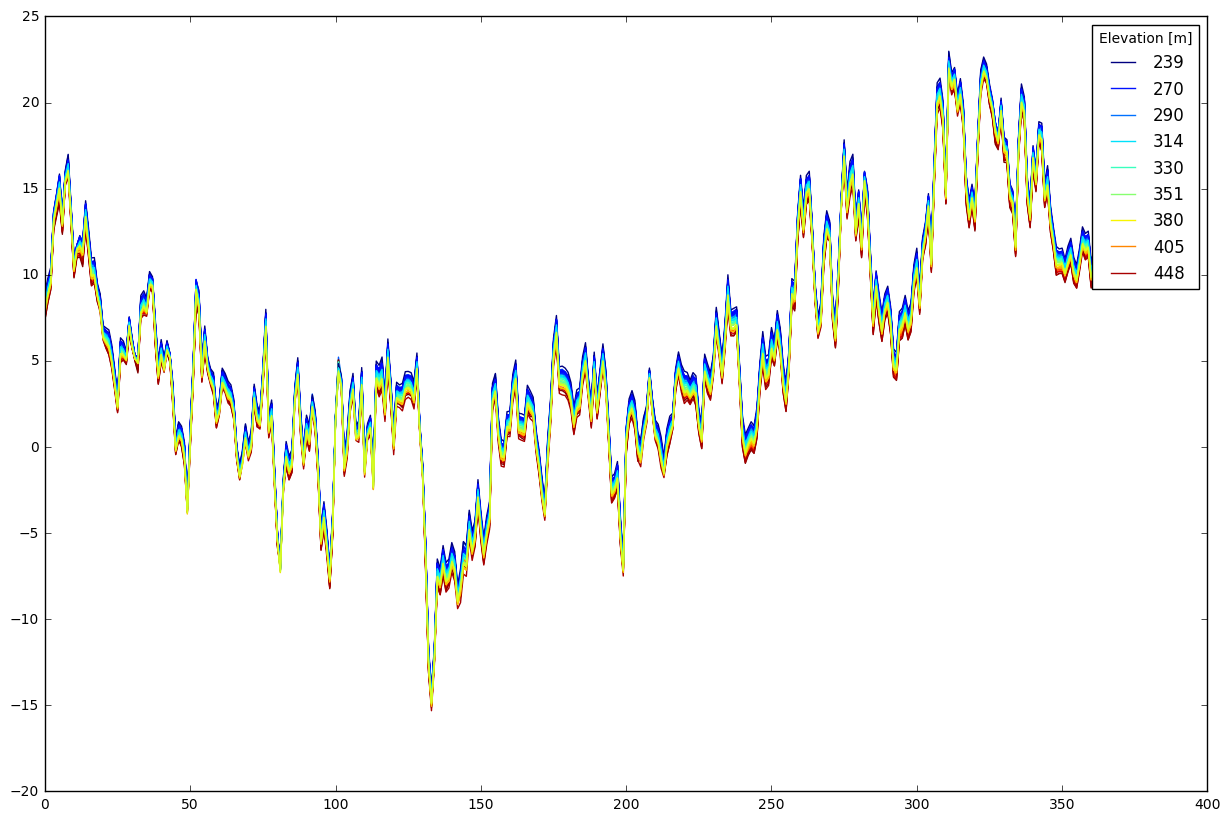

In [20]:
from matplotlib.cm import jet as jet
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# get all the cells for one sub-catchment with 'id' == 1228
c1228 = [c for c in region_model.cells if c.geo.catchment_id() == 1228]

# for plotting, create an mpl normalizer based on min,max elevation
elv = [c.geo.mid_point().z for c in c1228]
norm = Normalize(min(elv), max(elv))

#plot with line color a function of elevation
fig, ax = plt.subplots(figsize=(15,10))

# here we are cycling through each of the cells in c1228
for dat,elv in zip([c.env_ts.temperature.values for c in c1228], [c.mid_point().z for c in c1228]):
    ax.plot(dat, color=jet(norm(elv)), label=int(elv))
    
    
# the following is just to plot the legend entries and not related to Shyft
handles, labels = ax.get_legend_handles_labels()

# sort by labels
import operator
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

# show legend, but only every fifth entry
ax.legend(handles2[::5], labels2[::5], title='Elevation [m]')

As we would expect from the temperature kriging method, we should find higher elevations have colder temperatures. As an exercise you could explore this relationship using a scatter plot.

Now we're going to create a function that will read initial states from the `initial_state_repo`. In practice, this is already done by the `ConfgiSimulator`, but to demonstrate lower level functions, we'll reset the states of our `region_model`:

In [15]:
# create a function to read the states from the state repository
def get_init_state_from_repo(initial_state_repo_, region_model_id_=None, timestamp=None):
    state_id = 0
    if hasattr(initial_state_repo_, 'n'):  # No stored state, generated on-the-fly
        initial_state_repo_.n = region_model.size()
    else:
        states = initial_state_repo_.find_state(
            region_model_id_criteria=region_model_id_,
            utc_timestamp_criteria=timestamp)
        if len(states) > 0:
            state_id = states[0].state_id  # most_recent_state i.e. <= start time
        else:
            raise Exception('No initial state matching criteria.')
    return initial_state_repo_.get_state(state_id)
 
init_state = get_init_state_from_repo(initial_state_repo, region_model_id_=region_model_id, timestamp=region_model.time_axis.start)


Don't worry too much about the function for now, but do take note of the `init_state` object that we created. This is another container, this time it is a class that contains `PTGSKState` objects, which are specific to the model stack implemented in the simulation (in this case `PTGSK`). If we explore an individual state object, we'll see `init_state` contains, for each cell in our simulation, the state variables for each 'method' of the method stack.

Let's look more closely:

In [16]:
def print_pub_attr(obj):
    #only public attributes
    print([attr for attr in dir(obj) if attr[0] is not '_']) 
    
print(len(init_state))
init_state_cell0 = init_state[0]
# gam snow states
print_pub_attr(init_state_cell0.gs)

#init_state_cell0.kirchner states
print_pub_attr(init_state_cell0.kirchner)

4650
['acc_melt', 'albedo', 'alpha', 'iso_pot_energy', 'lwc', 'sdc_melt_mean', 'surface_heat', 'temp_swe']
['q']


#### Summary
We have now explored the `region_model` and looked at how to instantiate a `region_model` by using a `api.ARegionEnvironment`, containing a collection of timeseries sources, and passing an `api.InterpolationParameter` class containing the parameters to use for the data interpolation algorithms. The interpolation step "populated" our cells with data from the point sources.

The cells each contain all the information related to the simulation (their own timeseries, `env_ts`; their own model parameters, `parameter`; and other attributes and methods). In future tutorials we'll work with the cells indivdual "resource collector" (`.rc`) and "state collector" (`.sc`) attributes.



